# Deep learning in genomics

This notebook is based on the [jupyter notebook](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) from the publication ["A primer on deep learning in genomics"](https://www.nature.com/articles/s41588-018-0295-5) but uses the [fastai](https://www.fast.ai) library based on [PyTorch](https://pytorch.org).

# Notebook setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
import pdb

In [4]:
# fastai version
__version__

'1.0.36.post1'

# Data setup

## Load data from the web, generate dataframe, and save to disk

In [5]:
import requests

In [6]:
URL_seq = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

In [7]:
# get data from URL
seq_raw = requests.get(URL_seq).text.split('\n')
seq_raw = list(filter(None, seq_raw)) # Removes empty lists

In [8]:
# check length
len(seq_raw)

2000

In [9]:
# setup df from list
seq_df = pd.DataFrame(seq_raw, columns=['Sequences'])

In [10]:
# show head of dataframe
#seq_df.head()

In [11]:
URL_labels = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

In [12]:
seq_labels = requests.get(URL_labels).text.split('\n')
seq_labels = list(filter(None, seq_labels)) # Removes empty entries

In [13]:
len(seq_labels)

2000

In [14]:
seq_label_series = pd.Series(seq_labels)

In [15]:
seq_df['Target'] = seq_label_series.astype('int')

In [16]:
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


In [67]:
seq_df.to_csv('seq_df.csv')

## Data frame setup

In [5]:
seq_df = pd.read_csv('seq_df.csv', index_col=0)

In [7]:
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


### Target setup

In [8]:
targA = seq_df['Target'].values; targA

array([0, 0, 0, 1, ..., 1, 0, 1, 1])

In [253]:
targB = np.logical_not(seq_df['Target'].values).astype(int); targB

array([1, 1, 1, 0, ..., 0, 1, 0, 0])

In [254]:
targ = [[a,b] for a, b in zip(targA, targB)]; targ[:4], '...', targ[-4:]#, len(targ)

([[0, 1], [0, 1], [0, 1], [1, 0]], '...', [[1, 0], [0, 1], [1, 0], [1, 0]])

## Dataset setup for training with basic PyTorch

### Setup sqeuence to array function

In [11]:
def seq2array(seq:str)->List:
    "Return `List` object with np.array created from sequence string `seq`."
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    enc = enc.toarray().T # export sparse matrix to np array
    
    return enc

In [12]:
# test open sequence function
test_arr = seq2array('CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC'); test_arr, test_arr.shape

(array([[0., 0., 0., 1., ..., 0., 1., 0., 0.],
        [1., 1., 0., 0., ..., 1., 0., 1., 1.],
        [0., 0., 1., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]]), (4, 50))

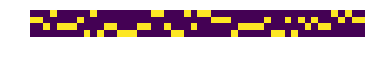

In [13]:
plt.imshow(test_arr)
plt.axis('off');

In [51]:
test_ten = tensor(test_arr).type(torch.float); test_ten

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.],
        [0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
         0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
         0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
         0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [53]:
# run test data through network
net_basic(test_ten[None])

tensor([[-2.7932,  2.6483]], grad_fn=<ThAddmmBackward>)

### Setup datasets

In [26]:
x = [tensor(seq2array(s)).type(torch.float) for s in seq_df['Sequences'].values]

In [27]:
x = torch.stack(x) # convert list to tensor

In [354]:
y = tensor(targ).view(-1,2).type(torch.float) # multi-label
#y = tensor(targA).type(torch.float) # classification with single label

In [355]:
y

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]])

In [356]:
len(x), len(y)

(2000, 2000)

In [357]:
# check data
i = 2
x[i], y[i]

(tensor([[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
          0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
          0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
          1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]]),
 tensor([0., 1.]))

In [358]:
# split dataset
train_ds = TensorDataset(x[:1500],y[:1500])
valid_ds = TensorDataset(x[-500:],y[-500:])

In [359]:
# verify dataset length
len(train_ds), len(valid_ds)

(1500, 500)

# Model setup

## Basic model for PyTorch training

In [360]:
def Flatten(): return Lambda(lambda x: x.view((x.size(0), -1)))

In [361]:
drop_p = 0.2

In [362]:
# inplace=True seems to generate problems?

In [363]:
net_basic = nn.Sequential(nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12),
                    nn.MaxPool1d(kernel_size=4),
                    Flatten(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=288, out_features=16),
                    nn.ReLU(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=16, out_features=2),
                    #nn.Dropout(drop_p), # not at the end?
                    #Debugger()
                   )

In [364]:
# check network architecture
net_basic

Sequential(
  (0): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Lambda()
  (3): Dropout(p=0.2)
  (4): Linear(in_features=288, out_features=16, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2)
  (7): Linear(in_features=16, out_features=2, bias=True)
)

In [385]:
# initialize weights with kaiming normal initialization
apply_init(net_basic, nn.init.kaiming_normal_)

# Model training

## Train basic model with PyTorch

In [386]:
bs = 64

In [387]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs*2, shuffle=False)

In [388]:
opt = optim.SGD(net_basic.parameters(), lr=1e-3, momentum=0.9)

In [389]:
# Based on https://github.com/fastai/fastai_docs/blob/master/dev_nb/mnist_sample.py

def simple_loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [392]:
# Based on https://github.com/fastai/fastai_docs/blob/master/dev_nb/mnist_sample.py

def simple_fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl: simple_loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[simple_loss_batch(model, loss_func, xb, yb)
                                for xb,yb in valid_dl])
            
            # Accuracy metric:          
            y_hat = [model(xb) for xb, _ in valid_dl]
            y_true = [yb for _, yb in valid_dl]
            
            
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        acc = accuracy_thresh(torch.cat(y_hat), torch.cat(y_true))
        
        print(epoch, val_loss, acc.detach().item())

In [393]:
simple_fit(50, net_basic, F.binary_cross_entropy_with_logits, opt, train_dl, valid_dl)

0 0.6370319695472717 0.7210000157356262
1 0.6338994307518006 0.7210000157356262
2 0.6318567461967468 0.7319999933242798
3 0.6278811850547791 0.7300000190734863
4 0.623628653049469 0.6959999799728394
5 0.6206430840492249 0.7369999885559082
6 0.6181680302619934 0.7459999918937683
7 0.6146262469291687 0.7459999918937683
8 0.610131974697113 0.7390000224113464
9 0.6068397688865662 0.75
10 0.6014331502914428 0.746999979019165
11 0.5954034461975097 0.7429999709129333
12 0.5876294298171997 0.7559999823570251
13 0.5818351955413819 0.7570000290870667
14 0.5782854886054992 0.7570000290870667
15 0.5749720005989075 0.765999972820282
16 0.5668742461204529 0.7680000066757202
17 0.5621699986457824 0.7760000228881836
18 0.5532165336608886 0.7760000228881836
19 0.5486772847175598 0.7870000004768372
20 0.5426526727676392 0.7839999794960022
21 0.5399251856803894 0.7960000038146973
22 0.5360337686538696 0.7990000247955322
23 0.5275813817977906 0.796999990940094
24 0.5187302412986755 0.7990000247955322
25 0